In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams.update({'font.size': 15})

#G=Goal, OG=Own Goal, Y=Yellow Card, R=Red Card, SY = Red Card by second yellow, P=Penalty, MP=Missed Penalty, I = Substitution In, O=Substitute Out, IH= In half time?

df_matches = pd.read_csv('data_raw/WorldCupMatches.csv', sep=',')
df_players = pd.read_csv('data_raw/WorldCupPlayers.csv', sep=',')
df_cups = pd.read_csv('data_raw/WorldCups.csv', sep=',')

df_events = pd.read_csv('data_prepared/event.csv', sep=',').replace(np.nan, '', regex=True)
df_penalties = pd.read_csv('data_prepared/penalties.csv', encoding='iso-8859-1', sep=',')

# Wie oft hat sich ein zurückliegendes Team den Sieg geholt?
* Es werden alle Spiele gezählt, bei denen das zur halbzeit zurückliegende Team den Sieg holt
* Spiele mit Verlängerung und Elfmeterschießen wurden aus Mangel eines Zwischenstandes am Spielende vor der verlängerung ausgeschlossen
* Spiele die am Ende der ersten Halbzeit unentschieden sind wurden auch nicht gezählt

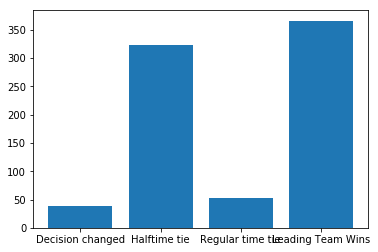

Insgesamt konnten 38 von Insgesamt 779 gedreht werden.


In [4]:
ht_wins_after_residual = 0
at_wins_after_residual = 0
halftime_tie = 0
regular_time_tie = 0
leading_team_wins = 0

df_grouped_events = df_events.groupby(["MatchID"]).mean()

for index, row in df_grouped_events.iterrows():
    # ignore penalties and extra time
    if row["Penalty"] == True or row["ExtraTime"] == True:
        continue
    if row["Half-time Home Goals"] == row["Half-time Away Goals"]:
        halftime_tie+=1
        continue
    if row["Home Team Goals"] == row["Away Team Goals"]:
        regular_time_tie +=1
        continue
    if row["Half-time Home Goals"] > row["Half-time Away Goals"] and row["Home Team Goals"] < row["Away Team Goals"]:
        at_wins_after_residual+=1
        continue
    if row["Half-time Home Goals"] < row["Half-time Away Goals"] and row["Home Team Goals"] > row["Away Team Goals"]:
        ht_wins_after_residual+=1
        continue  
    leading_team_wins+=1
    
decision_changed_after_ht = ht_wins_after_residual + at_wins_after_residual
y = [decision_changed_after_ht, halftime_tie, regular_time_tie, leading_team_wins]
x = ["Decision changed", "Halftime tie", "Regular time tie", "Leading Team Wins"]
plt.bar(x = x, height = y)

plt.show()

total_matches = decision_changed_after_ht + halftime_tie + regular_time_tie + leading_team_wins

print("Insgesamt konnten " + repr(decision_changed_after_ht) + " von Insgesamt " + repr(total_matches) + " gedreht werden.")

## Antwort: Von knapp 780 gezählten Spielen werden weniger als 40 Spiele gedreht

# Zu welcher Spielphase steht der Gewinner fest?
* Aufgrund einer häufigen Änderung des Spielmodus innerhalb der verschiedenen WM´s wurden nur die WM´s seit 1986 betrachtet, da sich bei diesen der Spielmodus nur marginal geändert hat
* Gruppen- und K.O.-Phase werden separat betrachtet

In [5]:
# data preparation: event data since 1986
df_relevant_events=df_events.loc[(df_events['Year'] >= 1986)]
df_relevant_events = df_relevant_events.groupby(["MatchID"]).mean()

# decide on group per game
first_half_decided_group = 0
second_half_decided_group = 0
first_half_decided = 0
second_half_decided = 0
extra_time_decided = 0
penalty_decided = 0

for index, row in df_relevant_events.iterrows():
    if row["Home Team Goals"] == row["Half-time Home Goals"] and row["Away Team Goals"] == row["Half-time Away Goals"] and row["Penalty"] == False:
        if row["Home Team Goals"] == row["Away Team Goals"]:
            continue
        if row["StageRank"] > 1:
            first_half_decided+=1
        else:
            first_half_decided_group+=1
        continue
    if row["ExtraTime"] == True and row["Penalty"] == False:
        extra_time_decided+=1
        continue
    if row["Penalty"] == True:
        penalty_decided+=1
        continue
    if row["StageRank"] > 1:
        second_half_decided+=1
    else:
        second_half_decided_group+=1

## Betrachtung der KO-Phase

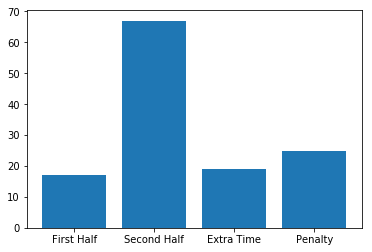

Gezählts Spiele: 128


In [8]:
match_decisions = [first_half_decided, second_half_decided, extra_time_decided, penalty_decided]
match_axis = ["First Half", "Second Half", "Extra Time", "Penalty"]
plt.bar(x = match_axis, height = match_decisions)

plt.show()

total_matches_ko = first_half_decided + second_half_decided + extra_time_decided + penalty_decided
print("Gezählts Spiele: " + repr(total_matches_ko))

## Betrachtung der Gruppen-Phase

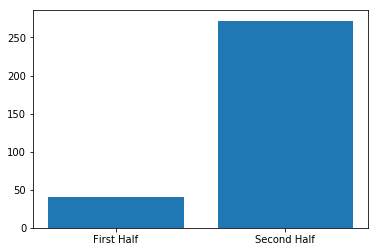

Gezählte Spiele: 312


In [9]:
match_decisions = [first_half_decided_group, second_half_decided_group]
match_axis = ["First Half", "Second Half"]
plt.bar(x = match_axis, height = match_decisions)

plt.show()
total_matches_group = first_half_decided_group + second_half_decided_group
print("Gezählte Spiele: " + repr(total_matches_group))

# Vorhersage zu welcher Spielphase sich ein Spiel entscheidet
* Hier soll mit einem KNN und einer Classification Decision Tree versucht werden, die ergebnisse von oben vorherzusagen
* Die Sinnhaftigkeit der Anwendung ist durchaus fraglich

In [10]:
# data prep
df_relevant_events # events since 1986
df_relevant_events = df_relevant_events.groupby(["MatchID"]).mean()

# lambda function to generate the base-truth
def calculateDecisionPhase(x):
    if x["Home Team Goals"] == x["Half-time Home Goals"] and x["Away Team Goals"] == x["Half-time Away Goals"] and x["Penalty"] == False:
        if x["Home Team Goals"] == x["Away Team Goals"]:
            return 0
        else:
            return 1
    if x["ExtraTime"] == True and x["Penalty"] == False:
        return 3
    if x["Penalty"] == True:
        return 4
    return 2

# lambda function to map the different stages of the cup to a boolean where 0 = group stage; 1 = k.o. stage
def calculateWorldCupStage(x):
    if x["StageRank"] == 1:
        return 0 # group phase
    return 1 # ko phase

# add the base-truth and the new stagerank to the dataframe
df_relevant_events_truth = df_relevant_events
df_relevant_events_truth["DecisionPhase"] = df_relevant_events_truth.apply(calculateDecisionPhase, axis=1)
df_relevant_events_truth["WorldCupStage"] = df_relevant_events_truth.apply(calculateWorldCupStage, axis=1)


## KNN

In [13]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

scaler = MinMaxScaler()

df_relevant_events_truth[["WorldCupStage", "Home Team Goals", "Half-time Home Goals", "Away Team Goals", "Half-time Away Goals", "ExtraTime", "Penalty"]] = scaler.fit_transform(df_relevant_events_truth[["WorldCupStage", "Home Team Goals", "Half-time Home Goals", "Away Team Goals", "Half-time Away Goals", "ExtraTime", "Penalty"]])
# Values
x = np.array(df_relevant_events_truth[["WorldCupStage", "Home Team Goals", "Half-time Home Goals", "Away Team Goals", "Half-time Away Goals", "ExtraTime", "Penalty"]])

# Labels
y = np.array(df_relevant_events_truth["DecisionPhase"]) 

# split the test data
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=101)

# fit decision tree
clf = KNeighborsClassifier()
clf = clf.fit(X_train, Y_train)

# compute accuracy
y_pred = clf.predict(X_test)
score = clf.score(X_test, Y_test)

train_score = accuracy_score(clf.predict(X_train), Y_train)

print("Anzahl der Datensätze: " + repr(len(y)))
print("Accruacy on Test Data: " + repr(score))
print("Accruacy on Training Data: " + repr(train_score))

Anzahl der Datensätze: 476
Accruacy on Test Data: 0.9370629370629371
Accruacy on Training Data: 0.9669669669669669


In [12]:
# for comparison also compute accuracy for base model (always output 2)
y_base_pred = np.full(shape = (len(Y_test)), fill_value=2) # two as most matches are decided in second half (see analysis above)
base_score = accuracy_score(y_base_pred, Y_test)
print("Base Accruacy: " + repr(base_score))

Base Accruacy: 0.6923076923076923


## Ergebnis des KNN: 
* Knapp 476 Datensätze
* Insgesamt 7 Features (Merkmale des Datensatzes)
    * Home Team Goals
    * Away Team Goals
    * Half Time Home Goals
    * Half Time Away Goals
    * Entra Time?
    * Penalty?
* Trainings Accuracy: 96,6%
* Test Accuracy: 93,7%
* Base Accuracy: 69,2% (Base = 2. Halbzeit entscheidend)

## Decision Tree

In [14]:
from sklearn import tree
from sklearn.metrics import accuracy_score

# fit decision tree
clf = tree.DecisionTreeClassifier(max_depth = 7)
clf = clf.fit(X_train, Y_train)

# compute accuracy
y_pred = clf.predict(X_test)
score = clf.score(X_test, Y_test)

train_score = accuracy_score(clf.predict(X_train), Y_train)

print("Accruacy bei Test Daten: " + repr(score))
print("Accruacy bei Trainings Daten: " + repr(train_score))

Accruacy bei Test Daten: 0.986013986013986
Accruacy bei Trainings Daten: 0.984984984984985


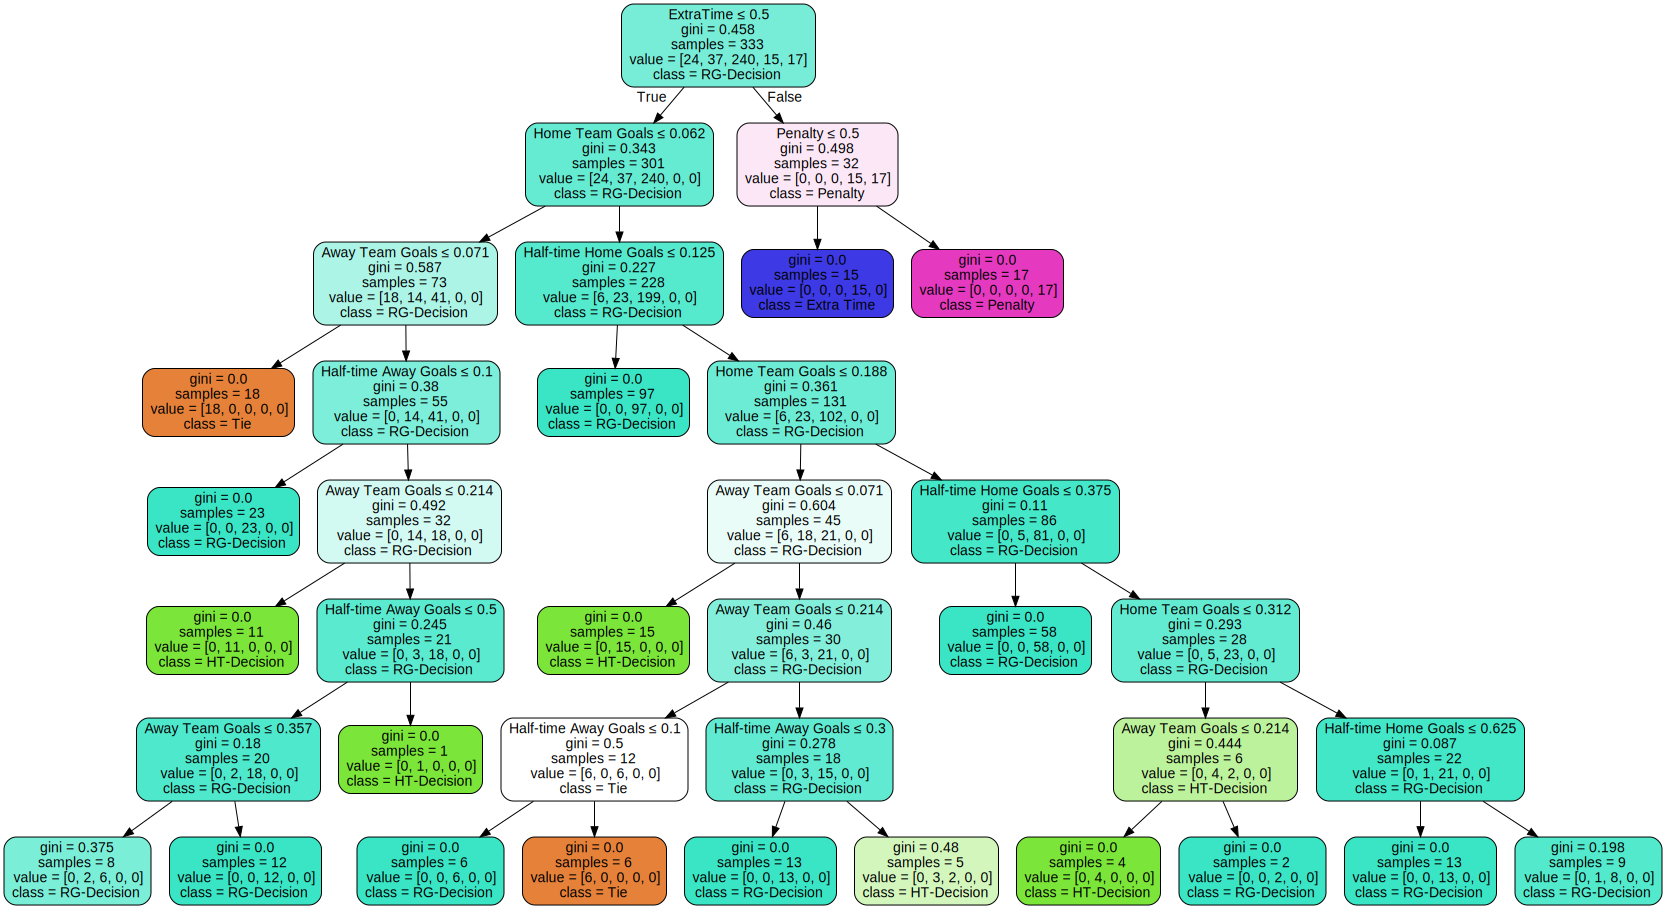

In [28]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=["WorldCupStage", "Home Team Goals", "Half-time Home Goals", "Away Team Goals", "Half-time Away Goals", "ExtraTime", "Penalty"],  
                         class_names=["Tie", "HT-Decision", "RG-Decision", "Extra Time", "Penalty"],  
                         filled=True, rounded=True,  
                         special_characters=True) 

graph = graphviz.Source(dot_data)  
graph

## Ergebnis des Decision Tree: 
* Knapp 440 Datensätze
* Insgesamt 7 Features (Merkmale des Datensatzes)
    * Home Team Goals
    * Away Team Goals
    * Half Time Home Goals
    * Half Time Away Goals
    * Entra Time?
    * Penalty?
* Trainings Accuracy: 98,5%
* Test Accuracy: 98,6%
* Base Accuracy: 69,2% (Base = 2. Halbzeit entscheidend)

# Erfolgsquote von Strafstößen

In [15]:
df_penalties_success_rate = df_events[(df_events.EventType.str.contains("P") == True)]
f = {
     'EventType':'count'
    }

df_penalties_success_rate = df_penalties_success_rate[["EventType"]].groupby(["EventType"]).agg(f)
df_penalties_success_rate

,EventType
EventType,
MP,11
P,178


In [16]:
df_penalties_MP = df_penalties_success_rate.loc["MP"]
df_penalties_P = df_penalties_success_rate.loc["P"]


In [17]:
df_penalties_MP

EventType    11
Name: MP, dtype: int64

In [18]:
df_penalties_P

EventType    178
Name: P, dtype: int64

In [19]:
df_penalty_quote = print(float(df_penalties_MP) / df_penalties_P)


EventType    0.061798
Name: P, dtype: float64


## Antwort: Nur 6,17 % der Strafstöße werden verschossen

# Allgemeine Informationen zur WM

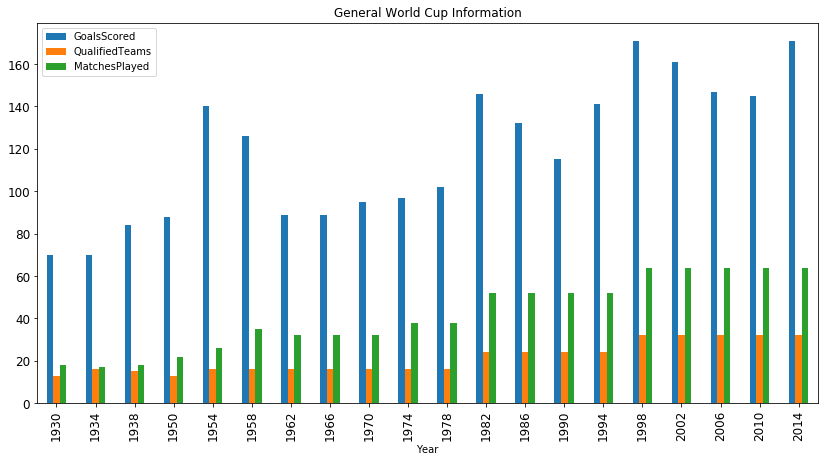

In [37]:
df_cups.set_index('Year').plot(kind='bar', title="General World Cup Information", figsize=(14,7), legend=True, fontsize=12)
plt.show()

# Zuschauerzahlen bei einer WM

In [38]:
# Data preparation
df_cups_attendance = df_cups[["Year", "Attendance"]]
df_cups_attendance['Attendance'] = df_cups_attendance['Attendance'].str.replace('.', '')
df_cups_attendance['Attendance'] = df_cups_attendance.Attendance.astype(float)
df_cups_attendance.dtypes

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Year            int64
Attendance    float64
dtype: object

## Gesamtzuschauerzahl pro WM

<Figure size 864x432 with 0 Axes>

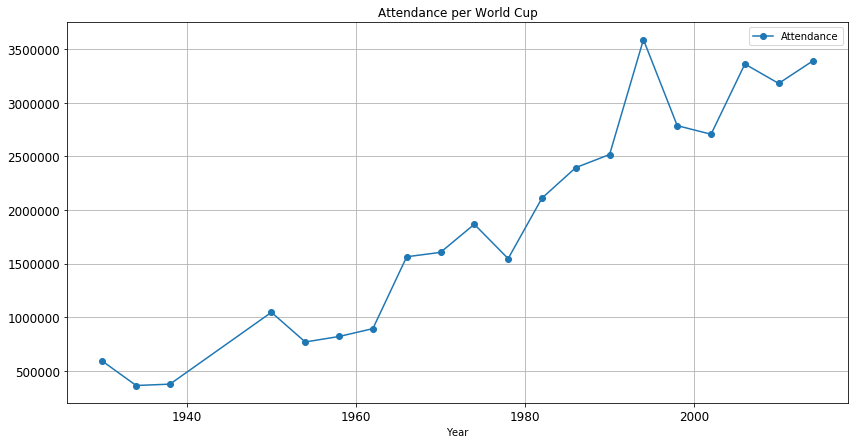

In [39]:
plt.figure(figsize=(12,6))
df_cups_attendance.set_index("Year").plot(style="o-", title="Attendance per World Cup", figsize=(14,7), legend=True, fontsize=12)
plt.grid()
plt.show()

## Durchschnittliche Besucherzahl pro WM

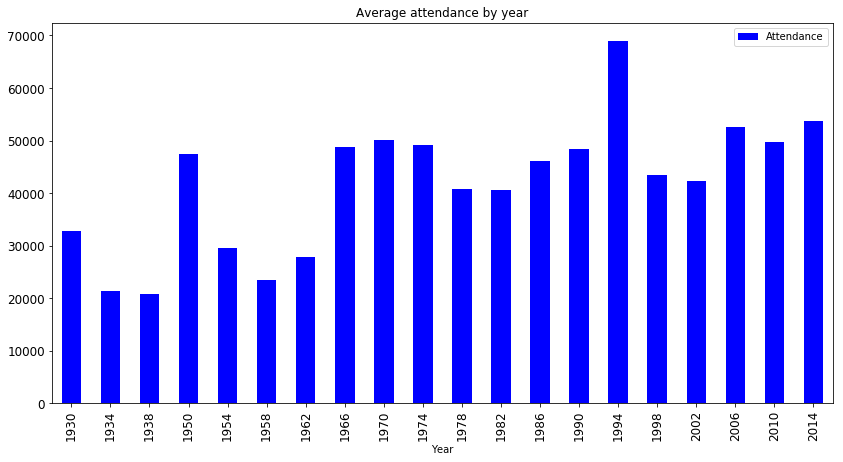

In [40]:
df_avg_attendance = df_matches.groupby("Year")["Attendance"].mean().reset_index()
df_avg_attendance["Year"] = df_avg_attendance["Year"].astype(int)
df_avg_attendance.set_index("Year").plot(kind='bar', color="b", title="Average attendance by year", figsize=(14,7), legend=True, fontsize=12)
plt.show()

# Spieler mit den meisten Toren über alle WM´s hinweg

In [41]:
# https://www.weltfussball.de/ewige_torjaeger/wm/tore/1/
# data consistency not sufficient for this calculation as player names are not unique

In [42]:
df_players_goals = df_events[["Player Name", "EventType"]]
df_players_goals = df_players_goals[df_players_goals.EventType.str.contains("G") == True]
df_players_goals = df_players_goals[df_players_goals.EventType.str.contains("P") == False]
df_players_goals = df_players_goals[df_players_goals.EventType.str.contains("I") == False]
df_players_goals = df_players_goals[df_players_goals.EventType.str.contains("Y") == False]
df_players_goals = df_players_goals[df_players_goals.EventType.str.contains("R") == False]
df_players_goals = df_players_goals[df_players_goals.EventType.str.contains("O") == False]

df_players_goals.groupby(["Player Name"])
df_players_goals.dropna()

,Player Name,EventType
2,Marcel LANGILLER,G
3,Juan CARRENO,G
6,Andre MASCHINOT,G
7,Andre MASCHINOT,G
15,Lucien LAURENT,G
36,Tom FLORIE,G
42,Bart McGHEE,G
46,Bert PATENAUDE,G
74,Ivica BEK,G
75,PREGUINHO,G


## List der Spieler mit den meisten Toren

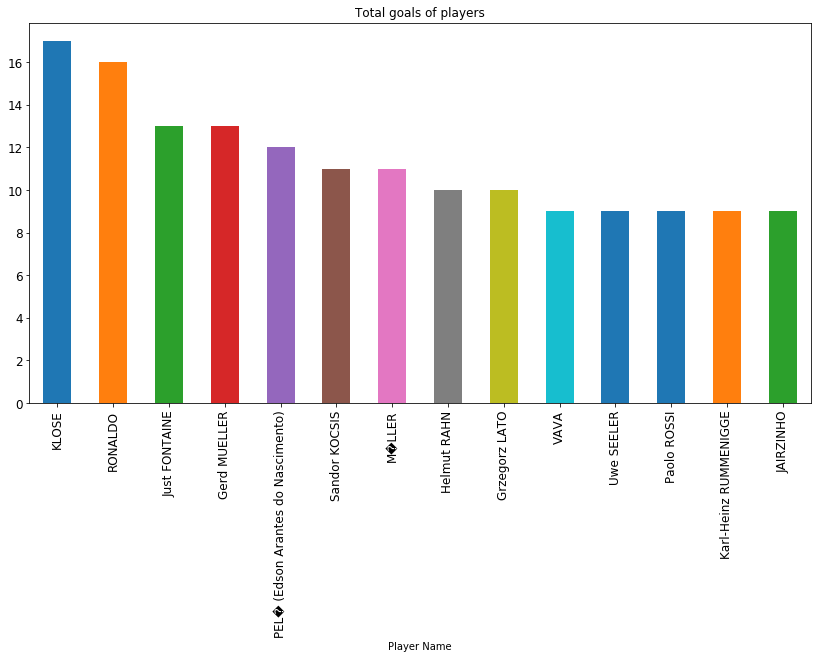

In [43]:
f = {
     'EventType':'count'
    }

df_test = df_players_goals.groupby(['Player Name']).agg(f)
df_test['EventType'].sort_values(ascending=False)
df_top_players = df_players_goals.groupby(['Player Name']).agg(f)
df_top_players['EventType'].sort_values(ascending=False)
df_top14_players = df_top_players[df_test.EventType > 8]
df_top14_players['EventType'].sort_values(ascending=False).plot(kind='bar', title="Total goals of players", figsize=(14,7), legend=False, fontsize=12)
plt.show()

# Spaß mit Elfmeterschießen

The used dataset covers only penalty shoot-outs after regular time. Penalty shoot-outs were introduced in 1972.

In [44]:
# data preparation
df_penalties["Match Result"] = df_penalties["Match Result"].str.replace("","-")
df_penalties["Final Result"] = df_penalties["Final Result"].str.replace("","-")

df_penalties["Winner Penalty Goals"] = df_penalties["Final Result"].str.split("-").str[0]
df_penalties["Loser Penalty Goals"]  = df_penalties["Final Result"].str.split("-").str[1]

## Überblick zu allen Elfmeterschießen

In [45]:
df_penalties

,Winner,Match Result,Loser,Year,Final Result,Round,Winner Penalty Goals,Loser Penalty Goals
0,Germany,3-3,France,1982,5-4,Semi-finals,5,4
1,France,1-1,Brazil,1986,4-3,Quarter-finals,4,3
2,Germany,0-0,Mexico,1986,4-1,Quarter-finals,4,1
3,Belgium,1-1,Spain,1986,5-4,Quarter-finals,5,4
4,Republic of Ireland,0-0,Romania,1990,5-4,Second round,5,4
5,Argentina,0-0,Yugoslavia,1990,3-2,Quarter-finals,3,2
6,Argentina,1-1,Italy,1990,4-3,Semi-finals,4,3
7,Germany,1-1,England,1990,4-3,Semi-finals,4,3
8,Bulgaria,1-1,Mexico,1994,3-1,Second round,3,1
9,Sweden,2-2,Romania,1994,5-4,Quarter-finals,5,4


## Wie viele Spiele wurden insgesamt durch Elfmeterschießen entschieden?

In [46]:
df_penalties[['Winner']].count()

Winner    26
dtype: int64

Between 1982 and 2014 took 26 penalty shoot-outs place

## Wie viele Elfmeterschießen gab es bei den WM´s der vergangenen Jahre?

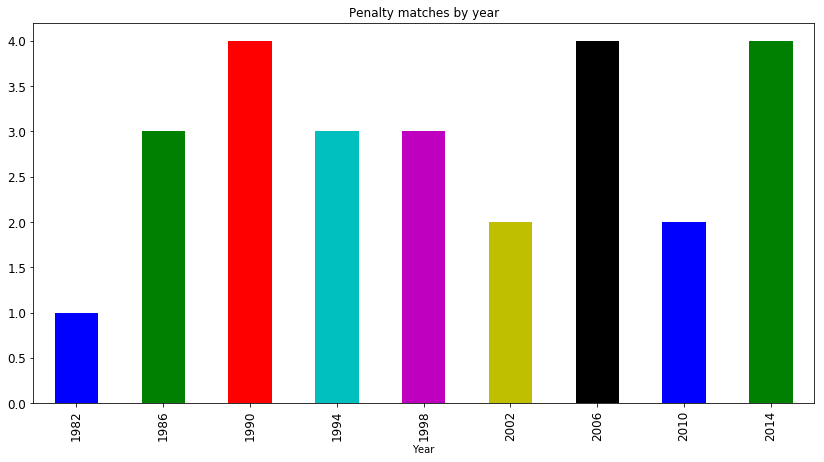

In [47]:
df_penalties_by_year = df_penalties['Year'].value_counts().reset_index()
df_penalties_by_year.columns = ['Year', 'Count']
df_penalties_by_year = df_penalties_by_year.sort_values(by='Year',ascending=True)
df_penalties_by_year.set_index("Year").plot(kind='bar',color='bgrcmyk', title="Penalty matches by year", figsize=(14,7), legend=False, fontsize=12)
plt.show()

## Wann gab es im WM Finale ein Elfmeterschießen?

In [48]:
df_penalties[df_penalties['Round'] == 'Final']

,Winner,Match Result,Loser,Year,Final Result,Round,Winner Penalty Goals,Loser Penalty Goals
10,Brazil,0-0,Italy,1994,3-2,Final,3,2
19,Italy,1-1,France,2006,5-3,Final,5,3


In 1994 won Brazil against Italy with the endresult of 3:2, and in 2006 won Italy against France in the world cup final 5:3.

## Welches Team hat die meisten Elfmeterschießen gewonnen?

In [49]:
df_penalty_winners = df_penalties["Winner"].value_counts().reset_index()
df_penalty_winners.columns = ["Country","Number of wins"]
df_penalty_winners.sort_values(by='Number of wins',ascending=False)

,Country,Number of wins
0,Argentina,4
1,Germany,4
2,Brazil,3
3,France,2
10,Bulgaria,1
15,Spain,1
14,Sweden,1
13,Republic of Ireland,1
12,Belgium,1
11,Italy,1


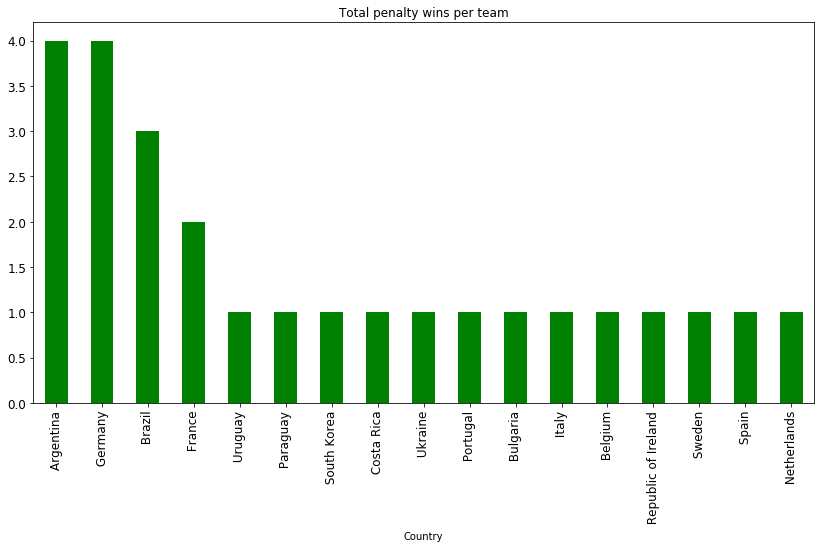

In [50]:
df_penalty_winners.set_index("Country").plot(kind="bar", color="g", title="Total penalty wins per team", figsize=(14,7), legend=False, fontsize=12)
plt.show()

## Welches Team schneidet beim Elfmeterschießen am schlechtesten ab?

In [51]:
df_penalty_loosers = df_penalties["Loser"].value_counts().reset_index()
df_penalty_loosers.columns = ["Country","Number of loses"]
df_penalty_loosers.sort_values(by='Number of loses',ascending=False)

,Country,Number of loses
0,Italy,3
1,England,3
2,Spain,2
3,Netherlands,2
4,France,2
5,Mexico,2
6,Romania,2
12,Costa Rica,1
15,Japan,1
14,Brazil,1


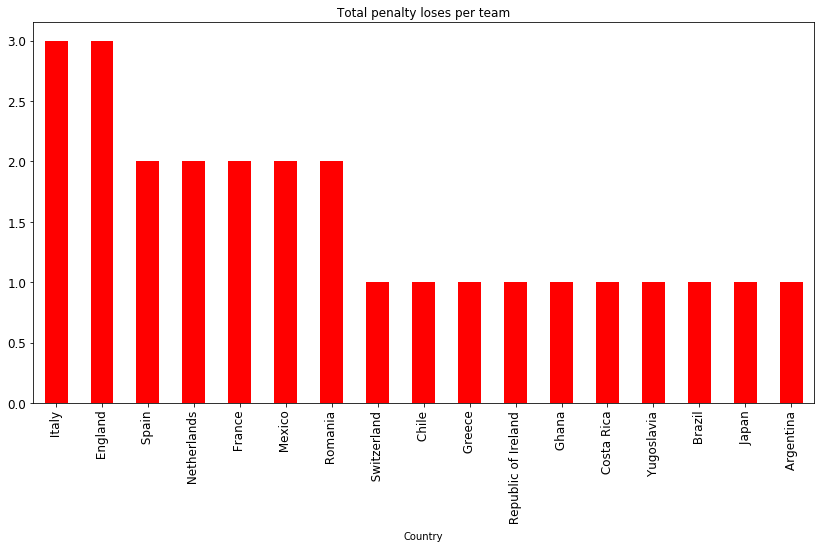

In [52]:
df_penalty_loosers.set_index("Country").plot(kind="bar", color="r", title="Total penalty loses per team", figsize=(14,7), legend=False, fontsize=12)
plt.show()

# Wie viele Tore wurden pro WM geschossen?

Year
1930     70
1934     70
1938     84
1950     88
1954    140
1958    126
1962     89
1966     89
1970     95
1974     97
1978    102
1982    146
1986    132
1990    115
1994    141
1998    171
2002    161
2006    147
2010    145
2014    171
dtype: int64


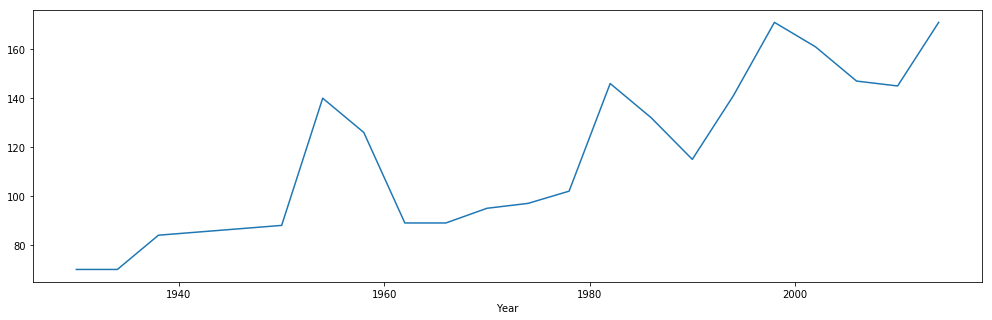

In [105]:
goals_per_match = df_events.groupby(['MatchID'])[['Year', 'Home Team Goals', 'Away Team Goals']].mean()
goals_per_world_cup = goals_per_match.groupby(['Year'])[['Home Team Goals', 'Away Team Goals']].sum()
print(goals_per_world_cup.sum(1))
goals_per_world_cup.sum(1).plot(figsize=(17,5))
plt.show()

# Die Anzahl der Tore hat zugenommen. Trifft das auch auf die Durchschnittliche Anzahl zu?

     Average Goals per Game
                           
Year                       
1930               0.257143
1934               0.242857
1938               0.214286
1950               0.250000
1954               0.185714
1958               0.277778
1962               0.359551
1966               0.359551
1970               0.336842
1974               0.391753
1978               0.372549
1982               0.356164
1986               0.393939
1990               0.452174
1994               0.368794
1998               0.374269
2002               0.397516
2006               0.435374
2010               0.441379
2014               0.374269


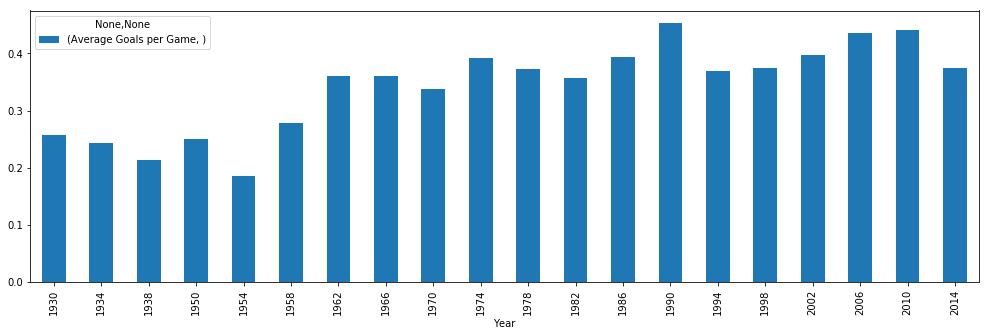

In [104]:
goals_per_match_ratio = df_events.groupby(['MatchID'])[['MatchID', 'Year', 'Home Team Goals', 'Away Team Goals']].mean()
goals_per_match_ratio = goals_per_match_ratio.assign(total = lambda x: x['Home Team Goals'] + x['Away Team Goals'])
goals_per_match_ratio = goals_per_match_ratio[['MatchID', 'Year', 'total']]
goals_per_match_ratio = goals_per_match_ratio.groupby(['Year'])[['MatchID', 'total']].agg({'MatchID' : ['size'], 'total' : ['sum']})
goals_per_match_ratio = goals_per_match_ratio.rename(columns={'size':'Number of Games', 'sum' : 'Amount of Goals'})
goals_per_match_ratio = goals_per_match_ratio.assign(average = lambda x: (x['MatchID']['Number of Games'].astype(dtype=float) / x['total']['Amount of Goals'].astype(dtype=float)) )
goals_per_match_ratio = goals_per_match_ratio[['average']].rename(columns={'average':'Average Goals per Game'})
print(goals_per_match_ratio)
goals_per_match_ratio.plot(kind='bar', figsize=(17,5))
plt.show()

Well it seems that yes, the average number of goals per game increased since 1930 but lately the average was more or less consistent with some peaks in the 00´s

# Hat ein Torhüter bei einer WM je ein Tor geschossen?

In [55]:
goal_keeper_goal = df_events.loc[(df_events['EventType'] == 'G') & (df_events['Position'] == 'GK')]

print(goal_keeper_goal)

Empty DataFrame
Columns: [Year, Datetime, Stage, Stadium, City, Home Team Name, Home Team Goals, Away Team Goals, Away Team Name, Attendance, Half-time Home Goals, Half-time Away Goals, Referee, Assistant 1, Assistant 2, RoundID, MatchID, Home Team Initials, Away Team Initials, Team Initials, Coach Name, Line-up, Shirt Number, Player Name, Position, EventType, EventMinute, ExtraTime, Penalty, GoldenGoal, DecisionPenaltyAway, DecisionPenaltyHome, HomeTeamWins, AwayTeamWins, EventOfHomeTeam, EventOfWinner, EventOfLoser, HourGameStart, StageRank]
Index: []

[0 rows x 39 columns]


## Nein

# Spielt der Gastgeber besser als sonst bei WM´s?

### Dafür soll zuerst der Host und der Weltmeister betrachtet werden

In [21]:
df_events2 = pd.read_csv('data_prepared/events2.csv', sep=';').replace(np.nan, '', regex=True)

host_and_winner = df_events2.loc[(df_events2['Stage'] == 'Final')]
host_and_winner = host_and_winner[['Year', 'Host Team Name', 'Home Team Name', 'Home Team Goals', 'Away Team Name', 'Away Team Goals', 'GoldenGoal', 'Penalty', 'DecisionPenaltyAway', 'DecisionPenaltyHome']]
host_and_winner = host_and_winner.drop_duplicates()
def calcChamp(x):
    if x['Penalty']:
        return x['Home Team Name'] if x['DecisionPenaltyHome'] > x['DecisionPenaltyAway'] else x['Away Team Name']
    else:
        return x['Home Team Name'] if x['Home Team Goals'] > x['Away Team Goals'] else x['Away Team Name']
host_and_winner['Champion'] = host_and_winner.apply(lambda x : calcChamp(x), axis=1)
host_and_winner = host_and_winner[['Year', 'Host Team Name', 'Champion']]
host_and_winner

,Year,Host Team Name,Champion
660,1930,Uruguay,Uruguay
1381,1934,Italy,Italy
2157,1938,France,Italy
4269,1954,Switzerland,Germany FR
5831,1958,Sweden,Brazil
7256,1962,Chile,Brazil
8682,1966,England,England
10124,1970,Mexico,Brazil
11840,1974,Germany FR,Germany FR
13562,1978,Argentina,Argentina


# Ok wie oft hat der Host die WM gewonnen?

In [22]:
host_won = host_and_winner.loc[(host_and_winner['Host Team Name'] == host_and_winner['Champion'])]
print(host_won)
num_host_won = len(host_won)
num_world_cups = len(host_and_winner)
print('That makes the Host win ' + repr(len(host_won)) + ' of ' + repr(len(host_and_winner)))
print('Which is a quote of: ' + repr(float(num_host_won)/num_world_cups))

       Year Host Team Name    Champion
660    1930        Uruguay     Uruguay
1381   1934          Italy       Italy
8682   1966        England     England
11840  1974     Germany FR  Germany FR
13562  1978      Argentina   Argentina
26079  1998         France      France
That makes the Host win 6 of 19
Which is a quote of: 0.3157894736842105


# Wie gut schneiden die Gastgeberländer durchschnittlich in einer WM ab?

In [82]:
df_hosts_list = host_and_winner["Host Team Name"]
df_year_list = host_and_winner["Year"]
df_year_list = df_year_list.reset_index()["Year"]
df_year_list

0     1930
1     1934
2     1938
3     1954
4     1958
5     1962
6     1966
7     1970
8     1974
9     1978
10    1982
11    1986
12    1990
13    1994
14    1998
15    2002
16    2006
17    2010
18    2014
Name: Year, dtype: int64

In [77]:
df_hosts_list = df_hosts_list.reset_index()["Host Team Name"]
df_hosts_list

0                   Uruguay
1                     Italy
2                    France
3               Switzerland
4                    Sweden
5                     Chile
6                   England
7                    Mexico
8                Germany FR
9                 Argentina
10                    Spain
11                   Mexico
12                    Italy
13                      USA
14                   France
15    Korean Republic/Japan
16                  Germany
17             South Africa
18                   Brazil
Name: Host Team Name, dtype: object

In [53]:
df_events2[['StageRank']].max()

StageRank    6
dtype: int64

In [54]:
df_events2[['StageRank']].min()

StageRank    0
dtype: int64

In [86]:
result_avg_host = []
result_avg_stage = []
result_avg_max_stage = []
result_avg_min_stage = []
result_stage_host_year = []

total_years = len(df_year_list)
for country_row in df_hosts_list:
    stage_count = 0
    stage_min = 7
    stage_max = 0
    for year_row in df_year_list:
        country_name = country_row
        year = year_row
        
        # begin determining the reached stage of the given host country in the given year
        df_avg_succ_rate = df_events2.loc[(df_events2['Home Team Name'] == country_name)|(df_events2["Away Team Name"] == country_name)]
        df_avg_succ_rate = df_avg_succ_rate.loc[(df_avg_succ_rate['Year'] == year)]
        df_avg_succ_rate = df_avg_succ_rate[['MatchID', 'Year', 'Home Team Name', 'Host Team Name', 'Away Team Name', 'StageRank']]
        df_avg_succ_rate = df_avg_succ_rate.drop_duplicates()
        max_stage = df_avg_succ_rate['StageRank'].max()
        if len(df_avg_succ_rate) == 0:
            max_stage = 0
        else:
            max_stage += 1 # shift the max_stage by one th make room for not participating
        
        stage_count += max_stage
        stage_min = stage_min if max_stage > stage_min else max_stage
        stage_max = stage_max if max_stage < stage_max else max_stage
        
    result_avg_host.append(country_row)
    result_avg_stage.append(float(stage_count)/total_years)
    result_avg_max_stage.append(stage_max)
    result_avg_min_stage.append(stage_min)

np_hosts = np.array(df_hosts_list)
np_years = np.array(df_year_list)
for i in range(len(df_year_list)):
    host = np_hosts[i]
    year = np_years[i]
    
    df_host_year_stages = df_events2.loc[(df_events2['Host Team Name'] == host)&(df_events2["Year"] == year)&((df_events2["Home Team Name"] == host) | (df_events2["Away Team Name"] == host))]
    reached_stage = df_host_year_stages["StageRank"].max()+1
    if len(df_host_year_stages) == 0:
        reached_stage = 0
    result_stage_host_year.append(reached_stage)
    
df_avg_host_performance = pd.DataFrame({ 'Year' : df_year_list, 'Host Country' : result_avg_host, 'Reached Stage': result_stage_host_year,'Avg. Reached Stage' : result_avg_stage, 'Lowest Stage Ever Reached' : result_avg_min_stage, 'Highest Stage Ever Reached' : result_avg_max_stage})#

df_avg_host_performance

,Year,Host Country,Reached Stage,Avg. Reached Stage,Lowest Stage Ever Reached,Highest Stage Ever Reached
0,1930,Uruguay,7.0,2.157895,0,7
1,1934,Italy,7.0,3.894737,0,7
2,1938,France,4.0,2.631579,0,7
3,1954,Switzerland,4.0,1.421053,0,4
4,1958,Sweden,7.0,1.842105,0,7
5,1962,Chile,5.0,1.157895,0,5
6,1966,England,7.0,2.526316,0,7
7,1970,Mexico,4.0,2.000000,0,4
8,1974,Germany FR,7.0,3.052632,0,7
9,1978,Argentina,7.0,3.421053,0,7


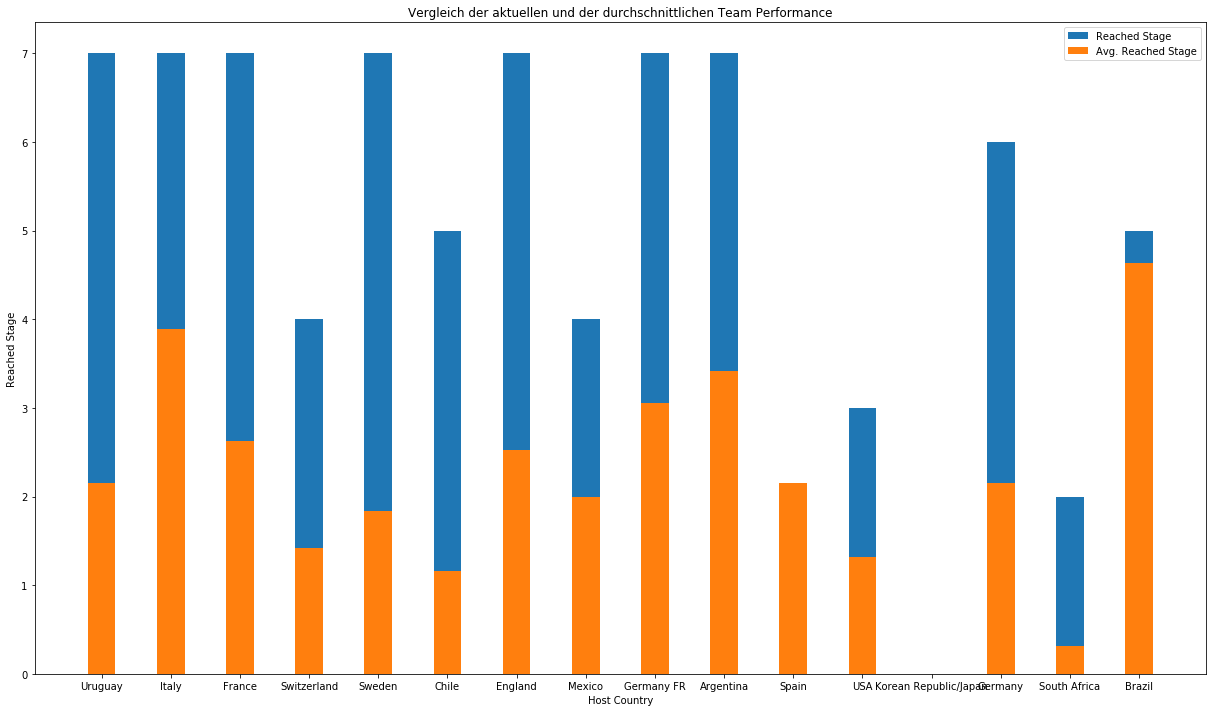

In [101]:
fig, ax = plt.subplots()
fig.set_size_inches(17,10)
index = df_avg_host_performance["Host Country"]
bar_width = 0.4

reached = ax.bar(index, df_avg_host_performance["Reached Stage"], bar_width, label='Reached Stage')
avg = ax.bar(index, df_avg_host_performance["Avg. Reached Stage"], bar_width, label='Avg. Reached Stage')

ax.set_xlabel('Host Country')
ax.set_ylabel('Reached Stage')
ax.set_title('Vergleich der aktuellen und der durchschnittlichen Team Performance')
ax.legend()

fig.tight_layout()
plt.show()

### Folgendes ergibt sich:
* Im Allgemeinen sind die Gastgeberländer auch große Fußballnationen
* In der Regel ist das Ergebnis des eines Teams im eigenen Land am Besten
* Außname bildet hier Spanien, die in ihrer Heim WM etwas unter dem erwarteten Durchschnitt blieben
* Für die WM 2002 wo Südkorea und Japan Gastgeberland waren wurde keine Untersuchung durchgeführt